## 태스크 2: 모델 훈련

기계 학습(ML) 모델 생성 프로세스는 데이터 처리부터 시작합니다. 데이터 처리가 완료되면 모델을 훈련할 ML 알고리즘을 선택합니다. 모델 훈련의 목표는 향후 데이터로 예측하는 데 사용할 수 있는 모델을 생성하는 것입니다. 처리한 데이터에는 대상이 포함되어야 하지만 향후 데이터에는 대상이 포함되지 않습니다(레이블이 지정되지 않음). 이 알고리즘은 입력 데이터 속성을 대상에 매핑하는 패턴을 훈련 데이터에서 찾습니다. 그런 후 알고리즘은 이러한 패턴을 캡처하는 ML 모델을 출력합니다. 모델이 있는 경우 대상 값이 포함되지 않는 새 데이터에 대해 예측을 수행할 수 있습니다.

예를 들어, 이메일이 스팸인지 여부를 예측하도록 ML 모델을 훈련하려면 대상을 알 수 있는 이메일을 포함하는 훈련 데이터(이 경우 이메일이 스팸인지 여부를 알려 주는 레이블)를 모델에 제공합니다. 이 데이터를 사용하여 알고리즘은 이메일이 스팸인지 여부를 예측하는 모델을 생성합니다. 이 모델을 사용해서 향후 이메일 레이블을 예측할 수 있습니다.

이 태스크에서는 누군가의 소득이 50,000 USD 미만인지 여부를 예측합니다. 모델은 누군가의 소득이 50,000 USD 미만인지를 최대한 정확하게 예측할 수 있도록 훈련을 통해 자체적으로 최적화됩니다. 모델 훈련을 위해서는 훈련하는 데 사용하려는 알고리즘 종류를 비롯한 몇 가지 구성이 필요합니다. 이 태스크에서는 XGBoost(eXtreme 그래디언트 부스팅) 알고리즘을 사용합니다. 모델을 훈련할 때 하이퍼파라미터도 구성해야 합니다. 하이퍼파라미터는 훈련 작업 프로세스를 제어하는 파라미터입니다. 훈련 작업의 다양한 단계를 변경하도록 조정될 수 있습니다. 적절한 하이퍼파라미터 세트를 선택하는 일은 모델 성능 및 정확도 측면에서 중요합니다. 모델을 훈련한 후에는 모델을 평가하고 모델 아티팩트를 확인합니다.

### 태스크 2.1: 환경 설정

모델 훈련을 시작하기 전에 필요한 종속 항목을 모두 설치하십시오.

In [1]:
#Install matplotlib and restart kernel
%pip install matplotlib
%pip uninstall bokeh -y
%pip install bokeh==2.4.2
%pip install seaborn
%reset -f

# Install dependencies
import boto3
import io
import json
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import sagemaker
import sys
import time
import zipfile

from sagemaker.debugger import Rule, rule_configs
from IPython.display import FileLink, FileLinks
from sagemaker import image_uris
from IPython.display import display
from IPython.display import Image
from sagemaker.analytics import ExperimentAnalytics
from sagemaker.inputs import TrainingInput
from sagemaker.session import Session
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.xgboost.estimator import XGBoost
from time import gmtime, strftime

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sess = boto3.Session()
sm = sess.client('sagemaker')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 27.7 MB/s  0:00:00m0:00:010:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> **참고:** 위의 셀과 후속 셀을 모두 실행하고 나면 경고를 무시해도 됩니다. 

In [ ]:
Next, import the dataset. In a previous lab, you exported the data files from Amazon SageMaker Data Wrangler to an Amazon Simple Storage Service (Amazon S3) bucket. You split the dataset into training (70 percent), validation (10 percent), and test (20 percent) datasets. The training and validation datasets are used during training. The test dataset is used in model evaluation after deployment.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> **Note:** The Train, Validation and Test datasets created in a previous lab by Data Wrangler have been copied into this lab environment to an S3 bucket.

내장된 Amazon SageMaker XGBoost 알고리즘에서는 text/libsvm, text/csv, application/x-parquet 및 application/x-recordio-protobuf와 같은 여러 가지 데이터 형식이 지원됩니다. 이 실습에서는 훈련에 CSV 형식을 사용합니다. 

훈련, 검증 및 테스트 데이터세트 파일을 확인하려면 아래 단계를 수행하십시오.

<!-- 1. AWS Management Console로 이동합니다

1. AWS Management Console 상단의 검색 표시줄에서 `S3`를 검색하여 선택합니다.

1. 버킷 목록에서 이름에 **labdatabucket**이 포함된 Amazon S3 버킷을 선택합니다.

1. **scripts** 폴더, **data** 폴더, **train** 폴더를 차례로 선택합니다.

1. **adult_data_processed_train.csv** 파일을 선택하고 **Download**를 선택하여 해당 내용을 확인합니다.

1. 페이지 위쪽의 <i aria-hidden="true" class="fas fa-folder" style="color:white"></i> **/ ... /data/train/** 브레드크럼 링크에서 **data**를 선택합니다.

1. **validation** 폴더를 선택합니다.

1. **adult_data_processed_validation.csv** 파일을 선택하고 **Download**를 선택하여 해당 내용을 확인합니다.

1. **lab_2.ipynb** 노트북으로 돌아갑니다. -->

1. 왼쪽 메뉴 모음에서 버킷 아이콘을 선택합니다.

1. 버킷 목록에서 이름에 **labdatabucket**이 포함된 Amazon S3 버킷을 선택합니다.

.csv 파일을 열면 SageMaker Studio에서 새 탭이 열립니다. 

1. **scripts** 폴더, **data** 폴더, **train** 폴더 및 **adult_data_processed_train.csv** 파일을 차례로 선택(두 번 클릭)하여 해당 내용을 확인합니다.

1. 왼쪽 창의 <i aria-hidden="true" class="fas fa-folder" style="color:white"></i> **/ ... /data/train/** 브레드크럼 링크에서 **data**를 선택합니다. 브레드크럼에서 **data** 폴더를 선택했는지 확인합니다. **data** 폴더가 선택되어 있다면 **test**, **train**, **validation**의 3개 폴더가 표시됩니다. 

1. **validation** 폴더, **adult_data_processed_validation.csv** 파일을 차례로 선택(두 번 클릭)하여 해당 내용을 확인합니다.

**훈련** 및 **검증** 데이터세트 파일을 확인했습니다. 이제 훈련 작업이 해당 입력으로 사용하는 훈련 및 검증 경로를 구성합니다.

In [2]:
# Import the datasets
s3 = boto3.resource('s3')
for buckets in s3.buckets.all():
    if 'labdatabucket' in buckets.name:
        bucket = buckets.name
print("Bucket: ", bucket)
prefix = 'scripts/data'
output_path = 's3://{}/{}/output'.format(bucket, prefix)

# Configure the training paths
train_path = f"s3://{bucket}/{prefix}/train/adult_data_processed_train.csv"
validation_path = f"s3://{bucket}/{prefix}/validation/adult_data_processed_validation.csv"

# Set up the TrainingInput objects
train_input = TrainingInput(train_path, content_type='text/csv')
validation_input = TrainingInput(validation_path, content_type='text/csv')

# Print the training and validation paths
print(f'Training path: {train_path}')
print(f'Validation path: {validation_path}')

# Set the container, name, and tags
create_date = strftime("%m%d%H%M")
container = image_uris.retrieve(framework='xgboost',region=boto3.Session().region_name,version='1.5-1')
run_name = 'lab-2-run-{}'.format(create_date)

Bucket:  labdatabucket-us-west-2-252340769
Training path: s3://labdatabucket-us-west-2-252340769/scripts/data/train/adult_data_processed_train.csv
Validation path: s3://labdatabucket-us-west-2-252340769/scripts/data/validation/adult_data_processed_validation.csv


### 태스크 2.2: 추정기 객체 구성

추정기는 SageMaker 훈련을 위한 고급 인터페이스입니다. AWS Identity and Access Management(AWS IAM) 역할, 컴퓨팅 인스턴스 수 및 유형, Amazon S3 출력 경로와 같은 필수 파라미터를 제공하여 추정기 객체를 생성합니다. 이 실습에서는 SageMaker 일반 추정기에 대한 XGBoost 기본 제공 알고리즘을 사용합니다. XGBoost는 그래디언트 부스트 트리 알고리즘에서 유명하고 효율적인 오픈 소스 구현입니다. 그래디언트 부스팅은 더욱 단순하고 약한 모형 세트의 추정치의 앙상블을 결합하여 대상 변수를 정확하게 예측하려 시도하는 지도 학습 알고리즘입니다. XGBoost 알고리즘은 다양한 데이터 유형, 관계, 배포 및 미세 조정할 수 있는 다양한 하이퍼파라미터를 잘 처리합니다. 회귀, (이진 및 멀티클래스)분류 및 순위 문제에 대해 XGBoost를 사용할 수 있습니다. 이 경우 XGBoost를 사용하여 분류 문제(누군가의 소득이 50,000 USD 미만인지 여부)를 해결합니다.

이 실습에서는 *sagemaker.estimator.Estimator* 클래스를 사용하여 XGBoost 추정기를 생성합니다. 다음 예제 코드에서 XGBoost 추정기 이름은 *xgb_model*입니다. SageMaker 추정기를 생성하려면 다음 파라미터를 지정합니다.

- **image_uri**: 훈련 컨테이너 이미지 URI. 이 예제에서 SageMaker XGBoost 훈련 컨테이너 URI는 *image_uris.retrieve*를 사용하여 지정합니다.
- **role**: SageMaker가 사용자 대신 태스크(예: 훈련 결과 읽기, Amazon S3에서 모델 아티팩트 호출, Amazon S3에 훈련 결과 쓰기)를 수행하는 데 사용하는 IAM 역할. 
- **instance_count and instance_type**: 모델 훈련에 사용할 Amazon EC2 ML 컴퓨팅 인스턴스의 유형 및 수. 이 실습의 경우 CPU 4개, 16GB 메모리, Amazon Elastic Block Store(Amazon EBS) 스토리지, 높은 네트워크 성능을 갖는 단일 ml.m5.xlarge 인스턴스를 사용합니다.
- **output_path**: SageMaker가 모델 아티팩트 및 훈련 결과를 저장하는 S3 버킷의 경로.
- **sagemaker_session**: SageMaker API 작업과 훈련 작업이 사용하는 다른 AWS 서비스와의 상호 작용을 관리하는 세션 객체.
- **rules**: Amazon SageMaker Debugger 기본 제공 규칙 목록. 이 예제에서 create_xgboost_report() 규칙은 훈련 프로세스 및 결과에 대한 인사이트를 제공하는 XGBoost 보고서를 생성합니다.

In [3]:
xgb_model = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role, 
    instance_count=1, 
    instance_type='ml.m5.xlarge',
    output_path=output_path,
    sagemaker_session=sagemaker_session,
    rules=[
        Rule.sagemaker(
            rule_configs.create_xgboost_report(),
            rule_parameters={
                "save_interval": "5"
            }
        )
    ]
)

### 태스크 2.3: 하이퍼파라미터 구성

하이퍼파라미터는 모델 구조, 기능 및 성능을 직접 제어합니다. 하이퍼파라미터 튜닝을 통해 데이터 과학자는 최적의 결과를 위해 모델 성능을 조정합니다. 이 프로세스는 기계 학습의 필수적인 부분으로, 적절한 하이퍼파라미터 값을 선택하는 것이 성공에 중요한 요인입니다.

추정기의 *set_hyperparameters* 메서드를 호출하여 XGBoost 알고리즘에 대한 하이퍼파라미터를 설정할 수 있습니다.

XGBoost 하이퍼파라미터에 관한 자세한 내용은 [XGBoost 하이퍼파라미터](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html)를 참조하십시오.

In [4]:
xgb_model.set_hyperparameters(
    max_depth=5,
    eta=0.1,  # Slower learning
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
    verbosity=1,
    objective='binary:logistic',
    num_round=1000  # More rounds
)

### 태스크 2.4: SageMaker 훈련 작업 실행

지금까지 추정기 객체 및 하이퍼파라미터를 구성했으므로 모델을 훈련할 준비가 되었습니다. fit() 메서드는 훈련 스크립트를 시작합니다. 모델 훈련을 시작하려면 훈련 및 검증 데이터세트로 추정기의 fit() 메서드를 호출합니다. `wait=True`를 설정하는 경우 fit() 메서드는 진행 로그를 표시하고 훈련이 완료될 때까지 기다립니다.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> **참고:** 훈련을 실행하려면 약 3~4분이 소요됩니다.

In [5]:
xgb_model.fit(
    {
        "train": train_input,
        "validation": validation_input
    },
    wait=True
)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2026-01-18-14-21-35-565


2026-01-18 14:21:37 Starting - Starting the training job...
2026-01-18 14:22:00 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
...
2026-01-18 14:22:40 Downloading - Downloading the training image......
2026-01-18 14:23:40 Training - Training image download completed. Training in progress../miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2026-01-18 14:23:35.605 ip-10-0-82-37.us-west-2.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2026-01-18 14:23:35.629 ip-10-0-82-37.us-west-2.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2026-01-18:14:23:35:INFO] Imported framework sagemaker_xgboost_container.training
[2026-01-18:14:23:35:INFO] Failed to parse hyperparameter objective value binary:l

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> **참고:** 위 셀이 실행되는 동안 아래 단계를 진행하여 훈련 작업 진행 상황을 모니터링합니다. 

1. AWS 콘솔로 이동한 후 왼쪽 위의 검색 표시줄에서 Amazon SageMaker AI를 검색합니다.

2. SageMaker AI 콘솔의 왼쪽 창에서 **Training**을 선택하고 **Training jobs**를 선택합니다.  

3. **sagemaker-xgboost** 작업으로 시작되는 훈련 작업의 링크를 선택하여 작업 생성 진행 상황을 모니터링합니다.

4. 작업 상태가 **InProgress**에서 **Completed**로 변경될 때까지 기다립니다. 이는 작업 생성이 완료되었음을 나타냅니다. 처리에 최대 5분이 걸릴 수 있습니다.

5. 작업 상태가 **Failed**로 표시되면 위의 코드 셀을 다시 실행하고 작업 상태가 **InProgress**에서 **Completed**로 변경될 때까지 기다립니다.

6. 처리 작업 상태가 **Completed**로 변경되면 Notebook으로 돌아와서 다음 태스크를 진행합니다.

<i aria-hidden="true" class="fas fa-exclamation-circle" style="color:#7C5AED"></i> **주의:** 처리 작업이 완료될 때까지는 다음 코드 셀을 실행하지 마십시오.

<i aria-hidden="true" class="fas fa-clipboard-check" style="color:#18ab4b"></i> **예상 출력:** 추정기 및 하이퍼파라미터 구성이 올바르고 훈련 작업이 올바르게 시작된 경우 다음 출력이 표시됩니다.

```plain
************************
**** EXAMPLE OUTPUT ****
************************

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-08-09-20-09-56-628
2023-08-09 20:09:56 Starting - Starting the training job...
2023-08-09 20:10:19 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
......
2023-08-09 20:11:21 Downloading - Downloading input data...
2023-08-09 20:11:55 Training - Downloading the training image...
2023-08-09 20:12:20 Training - Training image download completed. Training in progress....
2023-08-09 20:12:56 Uploading - Uploading generated training model...
2023-08-09 20:13:20 Completed - Training job completed
..Training seconds: 107
Billable seconds: 107
```

XGBoost 보고서 Notebook이 호스팅되는 S3 위치를 정의할 경로 구성 프로세스가 포함되어 있습니다.

In [6]:
bucket, project_prefix = xgb_model.output_path[5:].split('/',1)
rule_output_prefix = project_prefix + "/" + xgb_model.latest_training_job.job_name + "/rule-output/CreateXgboostReport/xgboost_report.ipynb"

SageMaker Debugger에서 생성된 XGBoost 보고서에 제때 액세스할 수 있도록 waiter 함수가 포함되어 있습니다.

In [7]:

print("Waiting for the report to become available")

waiter = boto3.client('s3').get_waiter('object_exists')

waiter.wait(
    Bucket=bucket,
    Key=rule_output_prefix,
    WaiterConfig={
        'Delay': 15,
        'MaxAttempts': 60
    }
)

print('The report is now available!')

Waiting for the report to become available
The report is now available!


### 태스크 2.5: 모델 평가

훈련 작업이 완료된 후에는 SageMaker Debugger에서 생성된 XGBoost 훈련 보고서를 다운로드할 수 있습니다. XGBoost 훈련 보고서는 반복과 관련된 손실 함수, 특성 중요도, 혼동 행렬, 정확도 곡선 및 기타 훈련의 통계 결과와 같은 훈련 진행 및 결과에 대한 인사이트를 제공합니다. 

SageMaker XGBoost 훈련 작업의 경우 디버거 `CreateXgboostReport` 규칙을 사용하여 훈련 진행 및 결과에 대한 포괄적인 훈련 보고서를 수신합니다.

In [8]:
%%capture
rule_output_path = xgb_model.output_path + "/" + xgb_model.latest_training_job.job_name + "/rule-output"
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive
! aws s3 cp {'s3://{}/{}'.format(bucket, rule_output_prefix)} ./

다음 셀 출력에 포함된 링크를 클릭하면 SageMaker Studio에서 새 탭이 열립니다. 여기서 설명하는 지침에 따라 작업을 진행하려면 다음 옵션 중 하나를 사용하십시오.
- **옵션 1**: 탭을 나란히 표시합니다. 주 SageMaker Studio 창에서 분할 화면 보기를 생성하려면 **lab_2.ipynb** 탭을 옆쪽으로 끌거나 **lab_2.ipynb** 탭을 선택한 후 도구 모음에서 **File**과 **New View for Notebook**을 차례로 선택합니다. 그러면 XGBoost 보고서를 살펴볼 때 지침을 표시할 수 있습니다.
- **옵션 2**: SageMaker Studio 탭을 서로 전환하면서 지침에 따라 작업을 진행합니다. XGBoost 보고서 탐색을 완료한 후 **lab_2.ipynb** 탭을 선택하여 노트북으로 돌아옵니다.

In [9]:
display("Click link below to view the XGBoost Training notebook", FileLink("CreateXgboostReport/xgboost_report.ipynb"))

'Click link below to view the XGBoost Training notebook'

/home/sagemaker-user/Lab3Repository/ko_kr/CreateXgboostReport/xgboost_report.ipynb

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> **참고:** 이 코드를 실행하면 출력으로 **'Click link below to view the XGBoost Training notebook' <span style="ssb_sm_blue">CreateXgboostReport/xgboost_report.ipynb</span>**가 표시됩니다.

새 탭에서 노트북을 열려면 링크를 선택합니다. 

<!-- 노트북이 열리면 **Set up notebook environment** 창에서 다음 항목을 구성합니다.

- **Image**에서 **Data Science 3.0**을 선택합니다.
- **Kernel**에서 **Python 3**를 선택합니다.
- **Select**를 선택합니다. -->

**xgboost_report.ipynb** 탭 상단에서 <i aria-hidden="true" class="fas fa-forward"></i> **Restart the kernel and run all cells** 버튼을 선택합니다. **Restart Kernel?** 메시지가 표시되면 **Restart**를 선택합니다.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> **참고:** 모든 셀을 실행하려면 2~3분 정도 걸립니다.

XGBoost 보고서의 섹션 관련 설명을 확인하려면 [디버거 XGBoost 훈련 보고서 안내](https://docs.aws.amazon.com/bedrock/latest/userguide/playgrounds.html)를 방문하십시오.

XGBoost 보고서의 모든 셀이 실행 완료되면 아래쪽으로 스크롤하여 **Confusion Matrix**를 선택합니다. 혼동 행렬은 관찰 결과의 예측 클래스와 실제 클래스를 비교하여 각 클래스에 대해 올바른 예측 및 잘못된 예측 수를 표로 나타냅니다. 다이어그램으로 이동하면 **참 긍정(TP)**, **참 부정(TN)**, **거짓 긍정(FP)** 및 **거짓 부정(FN)** 값이 표시됩니다.

- **참 긍정:** 실제 분류가 긍정이고 예측한 분류가 긍정(1,1)이면 긍정 샘플이 분류자에서 올바르게 분류된 것이므로 **참 긍정(TP)** 결과라고 합니다. 
- **거짓 부정:** 실제 분류가 긍정이고 예측한 분류가 부정(1,0)이면 긍정 샘플이 분류자에서 부정으로 잘못 분류된 것이므로 **거짓 부정(FN)** 결과라고 합니다. 
- **거짓 긍정:** 실제 분류가 부정이고 예측한 분류가 긍정(0,1)이면 부정 샘플이 분류자에서 긍정으로 잘못 분류된 것이므로 **거짓 긍정(TP)** 결과라고 합니다. 
- **참 부정:** 실제 분류가 부정이고 예측한 분류가 부정(0,0)이면 부정 샘플이 분류자에서 올바르게 분류된 것이므로 **참 부정(TN)** 결과라고 합니다.

다음으로 아래로 스크롤하여 **혼동 행렬의 평가**로 이동한 후 **분류 보고서**를 좀 더 자세히 확인하여 각 클래스의 정밀도, 재현율 및 F1 점수의 요약을 이해합니다.

- **정밀도**: 긍정으로 예측되는 모든 예제 중에서 긍정으로 예측된 실제 긍정값의 비율을 측정합니다. 범위는 0~1이고 값이 클수록 정확도가 더 좋은 것입니다. 정밀도는 모델이 관련성이 있다고 나타낸 데이터 포인트 중에서 실제로 관련성이 있는 비율을 나타냅니다. 정밀도는 특히 FP 비용이 높을 때 고려하기에 좋은 측정값입니다.
- **재현율/민감도/참 긍정 비율(TPR)**: 긍정으로 예측된 실제 긍정값의 비율을 측정합니다. 이 범위도 0~1이며 값이 클수록 예측 정확도가 더 높은 것입니다. 이것을 재현율/민감도라고도 합니다. 이 측정값은 데이터세트의 모든 관련 인스턴스를 찾는 능력을 나타냅니다.
- **F1 점수**: 정밀도 및 재현율의 조화 평균에 해당하는 대상 지표를 나타냅니다. F1은 FP 및 FN을 둘 다 고려하여 정밀도와 재현율에 동일한 가중치를 부여합니다.

자격 있는 시민에게 정부 지원 서비스를 홍보할 수 있도록 소득이 50,000 USD 미만인 경우를 예측하려고 합니다. 이 경우에 F1 점수는 FP(소득이 50,000 USD보다 높지만 50,000 USD 미만으로 레이블이 지정된 사람) 및 FN(소득이 50,000 USD보다 높은 것으로 레이블이 지정된 50,000 USD 미만인 사람)을 모두 고려하므로 사용하기에 적절한 측정값입니다. 정밀도 및 재현율이 모두 높으며 F1 점수가 두 측정값을 모두 고려하는지 확인하려고 합니다. 다음 실습에서는 하이퍼파라미터를 튜닝하면서 더 높은 F1 점수를 얻을 수 있는지 확인하여 모델을 최적화합니다.

이 모델의 **Precision**, **Recall**, **F1-Score** 및 **Overall Accuracy**는 무엇입니까?

<i aria-hidden="true" class="far fa-comment" style="color:#008296"></i> **고려 사항:** 노트북에 포함된 다른 그래프를 잠시 검토해 보십시오. 어떤 종류의 정보가 표시됩니까? 모델을 훈련할 때 도움이 될 만한 정보로는 어떤 것이 있습니까?

XGBoost 보고서의 **Feature importance** 섹션에는 특성이 f0, f1, f2 등으로 설명되어 있습니다. 이러한 특성은 훈련 및 검증 데이터세트의 열에 해당됩니다. 이러한 데이터세트에는 헤더 레코드가 없습니다. 아래에서 이러한 데이터세트의 열 설명을 참조할 수 있습니다.

```plain
Column 0 = income (label) 
f0 = age 
f1 = education 
f2 = education_num 
f3 = occupation
f4 = capital_gain
f5 = capital_loss
f6 = hours_per_week
f7 = marital_status_Married-civ-spouse
f8 = marital_status_Never-married
f9 = marital_status_Divorced
f10 = marital_status_Separated
f11 = marital_status_Widowed
f12 = marital_status_Married-spouse-absent
f13 = marital_status_Married-AF-spouse
f14 = race_White
f15 = race_Black
f16 = race_Asian-Pac-Islander
f17 = race_Amer-Indian-Eskimo
f18 = race_Other
f19 = relationship_Husband
f20 = relationship_Not-in-family
f21 = relationship_Own-child
f22 = relationship_Unmarried
f23 = relationship_Wife 
f24 = relationship_Other-relative
f25 = sex_Male
f26 = sex_Female
f27 = workclass_Private
f28 = workclass_Self-emp-not-inc
f29 = workclass_Local-gov
f30 = workclass_?
f31 = workclass_State-gov
f32 = workclass_Self-emp-inc
f33 = workclass_Federal-gov
```

### 태스크 2.6: 모델 아티팩트 확인

SageMaker AI는 S3 버킷에 모델 아티팩트를 저장합니다. 모델 아티팩트의 위치를 찾으려면 다음 단계를 따르십시오.

<!-- 1. AWS Management Console로 이동합니다

1. AWS Management Console 상단의 검색 표시줄에서 `S3`를 검색하여 선택합니다.

1. 버킷 목록에서 이름에 **labdatabucket**이 포함된 Amazon S3 버킷을 선택합니다.

1. **scripts/data/output/sagemaker-xgboost-.../output** 하위 폴더로 이동합니다.  -->

1. 왼쪽 메뉴 모음에서 버킷 아이콘을 선택합니다.

1. 버킷 목록에서 이름에 **labdatabucket**이 포함된 Amazon S3 버킷을 엽니다.

1. **scripts/data/output/ sagemaker-xgboost-.../output** 하위 폴더로 이동합니다. 

하위 폴더에 모델 아티팩트 **model.tar.gz**가 표시됩니다. 이것은 fit() 메서드를 호출하여 SageMaker Estimator로 생성한 모델입니다.

model.tar.gz 파일을 비롯한 모델 아티팩트를 확인했습니다. 

### 정리

이 노트북을 완료했습니다. 실습의 다음 부분으로 이동하려면 다음을 수행합니다.

- 노트북 파일을 닫습니다.
- 실습 세션으로 돌아가 **결론**을 계속 진행합니다.

In [11]:
%pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [imblearn]2/3 [imblearn]d-learn]
Note: you may need to restart the kernel to use updated packages.


In [12]:
#Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize']=(16, 8.27) #set graphs size to A4 dimensions
sns.set_style('darkgrid')
sns.set(font_scale = 1.4)

In [13]:
train = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)

test = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test' , skiprows = 1, header = None)

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num','marital_status', 'occupation','relationship', 
              'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'wage_class']
train.columns = col_labels
test.columns = col_labels

### Exploratory Data Analysis¶

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  wage_class      32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [15]:
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [16]:
train.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [17]:
#find out numerical and categorical features for train set

numerical_features=[feature for feature in train.columns if train[feature].dtype!='O']
categorical_features=[feature for feature in  train.columns if  train[feature].dtype=='O' and feature!='wage_class']

print('categorical features: ''\n',categorical_features)
print('\n')
print('numerical features: ''\n',numerical_features)

categorical features: 
 ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


numerical features: 
 ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


In [18]:
#Check for missing values
for feature in train.columns:
    print(feature,':', train[feature].isnull().sum())

age : 0
workclass : 0
fnlwgt : 0
education : 0
education_num : 0
marital_status : 0
occupation : 0
relationship : 0
race : 0
sex : 0
capital_gain : 0
capital_loss : 0
hours_per_week : 0
native_country : 0
wage_class : 0


In [19]:
#Find out distinct values for each numerical feature
for feature in numerical_features:
    print(feature,':', train[feature].nunique())

age : 73
fnlwgt : 21648
education_num : 16
capital_gain : 119
capital_loss : 92
hours_per_week : 94


In [20]:
#Find out distinct values for each categorical feature
for feature in categorical_features:
    print(feature,':', train[feature].nunique())

workclass : 9
education : 16
marital_status : 7
occupation : 15
relationship : 6
race : 5
sex : 2
native_country : 42


In [21]:
#for each categorical value we calculate relative frequency of unique classes.
for feature in categorical_features:
    freq=train[feature].value_counts('f').rename_axis(feature).reset_index(name='relative frequency')
    print('\n')
    print(freq)



           workclass  relative frequency
0            Private            0.697030
1   Self-emp-not-inc            0.078038
2          Local-gov            0.064279
3                  ?            0.056386
4          State-gov            0.039864
5       Self-emp-inc            0.034274
6        Federal-gov            0.029483
7        Without-pay            0.000430
8       Never-worked            0.000215


        education  relative frequency
0         HS-grad            0.322502
1    Some-college            0.223918
2       Bachelors            0.164461
3         Masters            0.052916
4       Assoc-voc            0.042443
5            11th            0.036086
6      Assoc-acdm            0.032769
7            10th            0.028654
8         7th-8th            0.019840
9     Prof-school            0.017690
10            9th            0.015786
11           12th            0.013298
12      Doctorate            0.012684
13        5th-6th            0.010227
14        1st-4t

In [22]:
#Check for imbalanced target (In our case 76% are in class <=50K and 24% >50K)
train['wage_class'].value_counts('f') 

wage_class
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64

---

##### Visualization

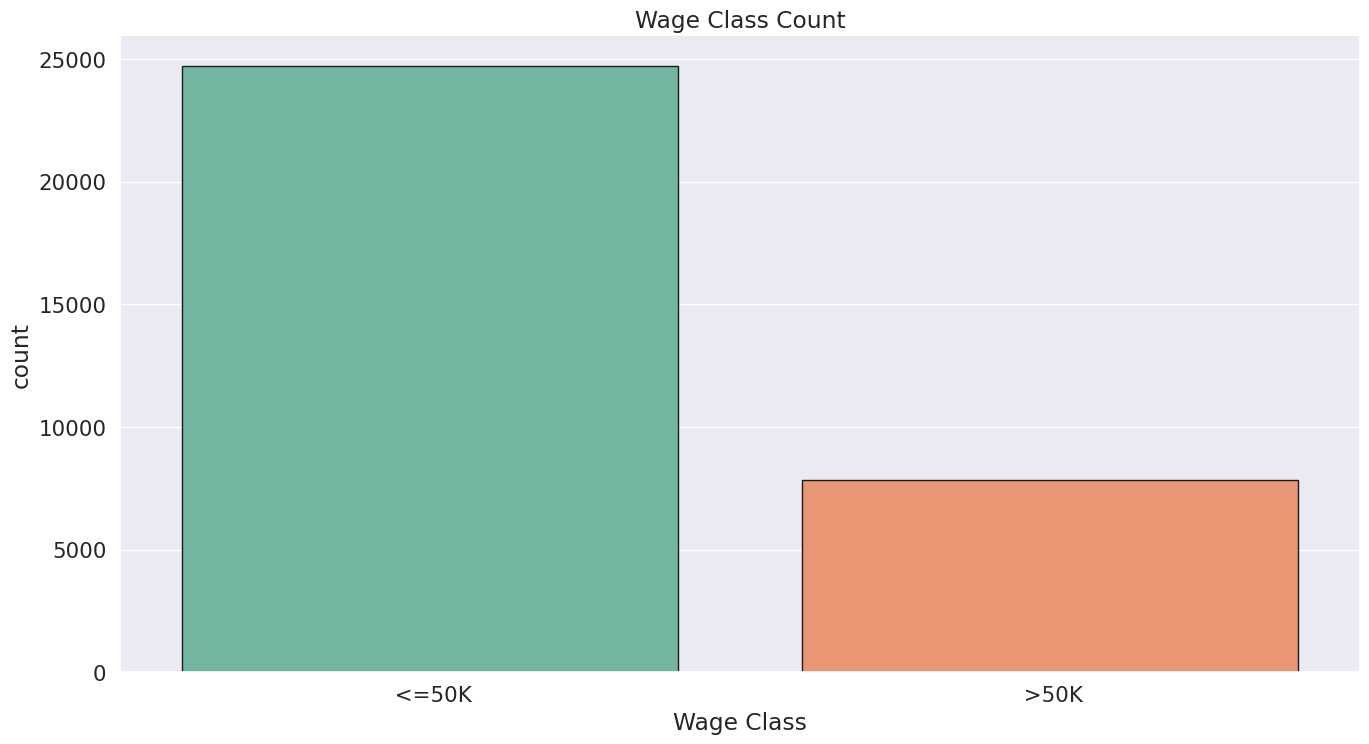

In [24]:
ax=sns.countplot(data=train,
    x='wage_class',
    hue='wage_class',
    edgecolor='k',
    palette='Set2')
ax.set_title('Wage Class Count')
ax.set_xlabel('Wage Class')
plt.show()

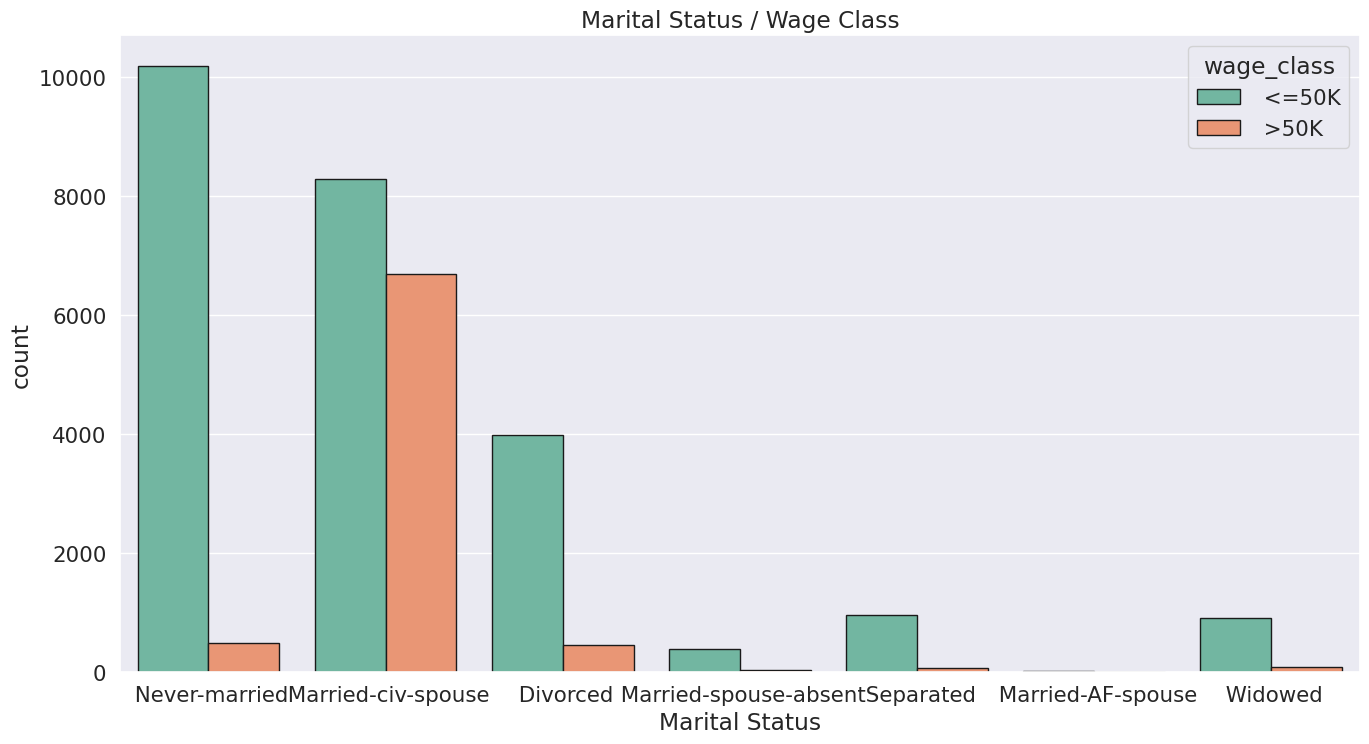

In [26]:
ax=sns.countplot(data=train,
    x='marital_status',
    hue='wage_class',
    edgecolor='k',
    palette='Set2')
ax.set_title('Marital Status / Wage Class')
ax.set_xlabel('Marital Status')
plt.show()

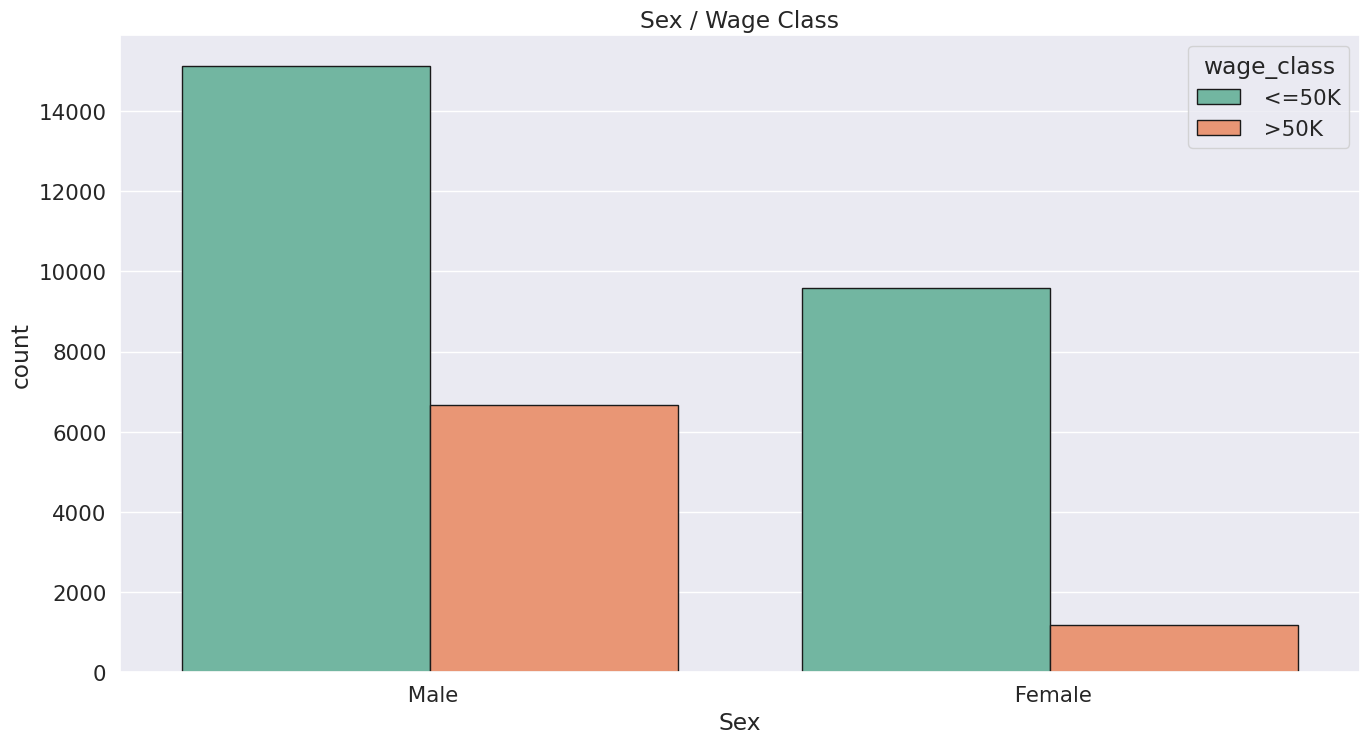

In [27]:
ax=sns.countplot(data=train,
    x='sex',
    hue='wage_class',
    edgecolor='k',
    palette='Set2')
ax.set_title('Sex / Wage Class')
ax.set_xlabel('Sex')
plt.show()

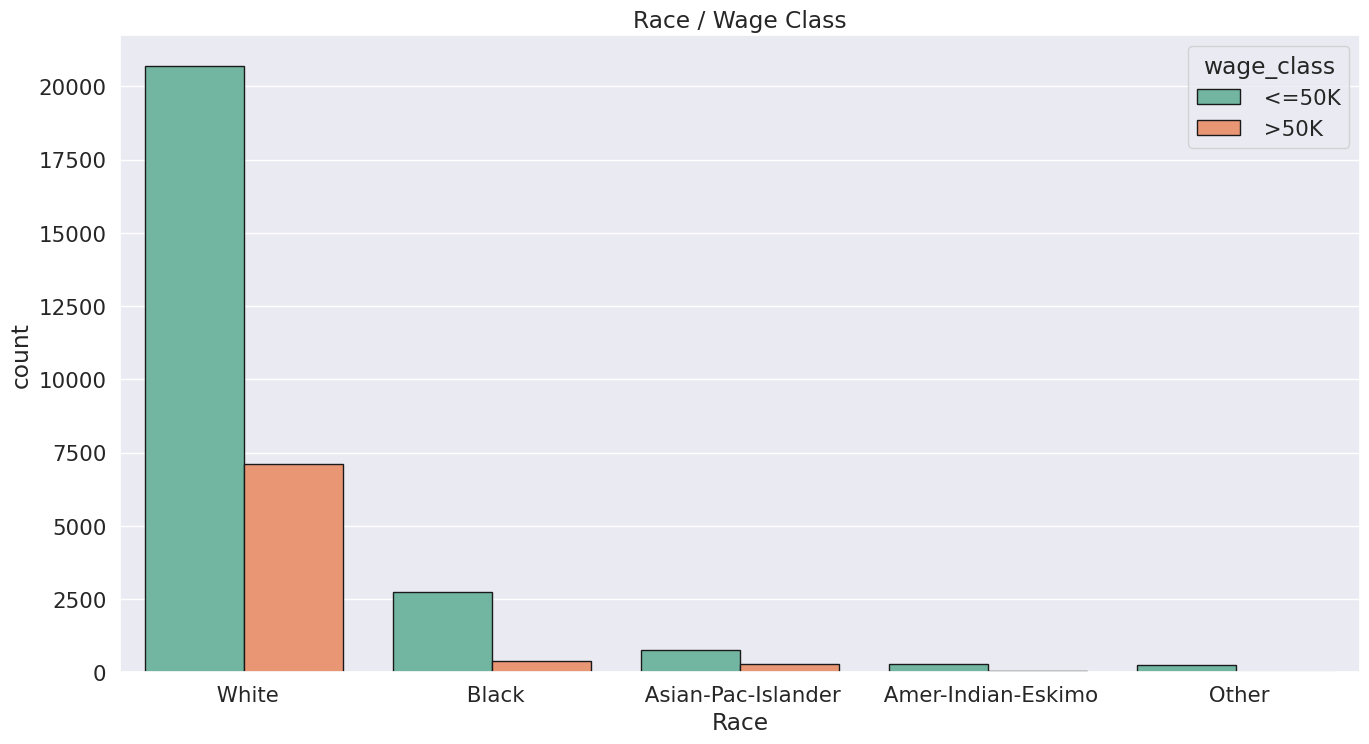

In [28]:
ax=sns.countplot(data=train,
    x='race',
    hue='wage_class',
    edgecolor='k',
    palette='Set2')
ax.set_title('Race / Wage Class')
ax.set_xlabel('Race')
plt.show()

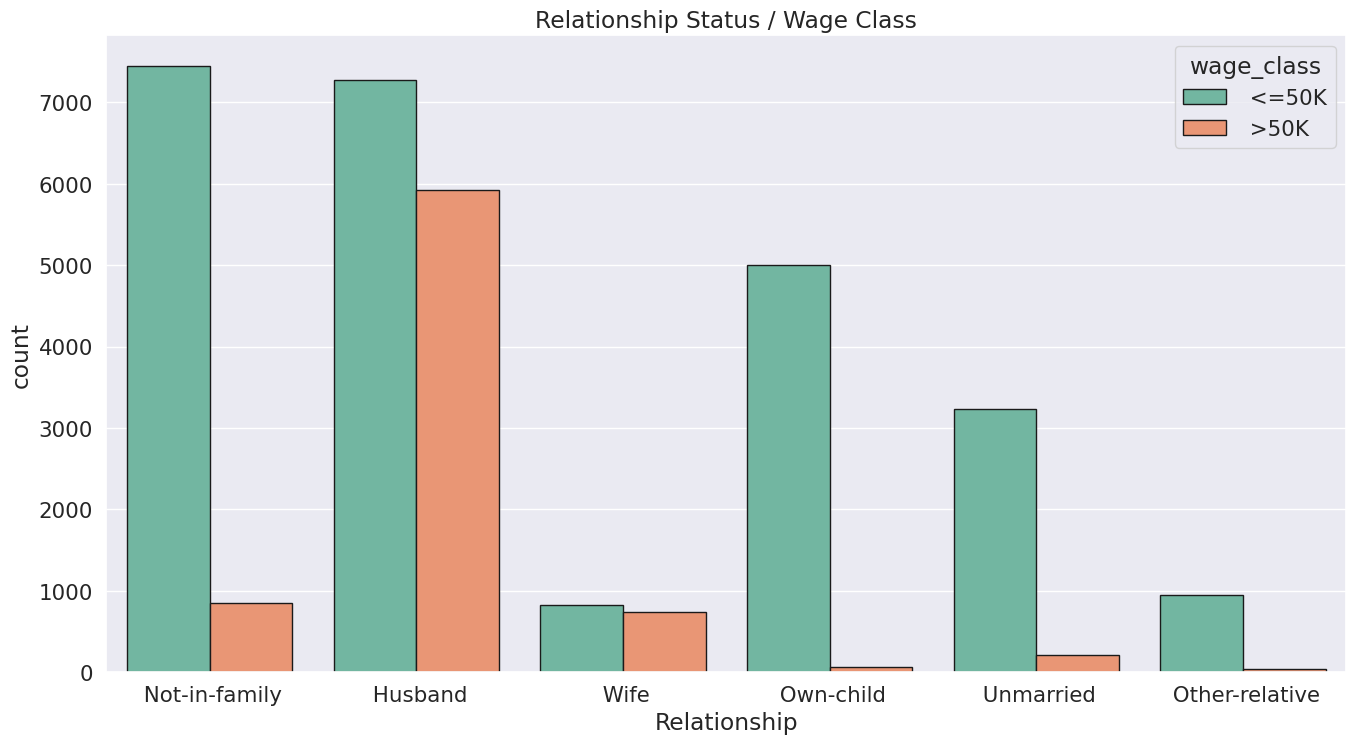

In [29]:
ax=sns.countplot(data=train,
    x='relationship',
    hue='wage_class',
    edgecolor='k',
    palette='Set2')
ax.set_title('Relationship Status / Wage Class')
ax.set_xlabel('Relationship')
plt.show()

/tmp/ipykernel_700/3738441375.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


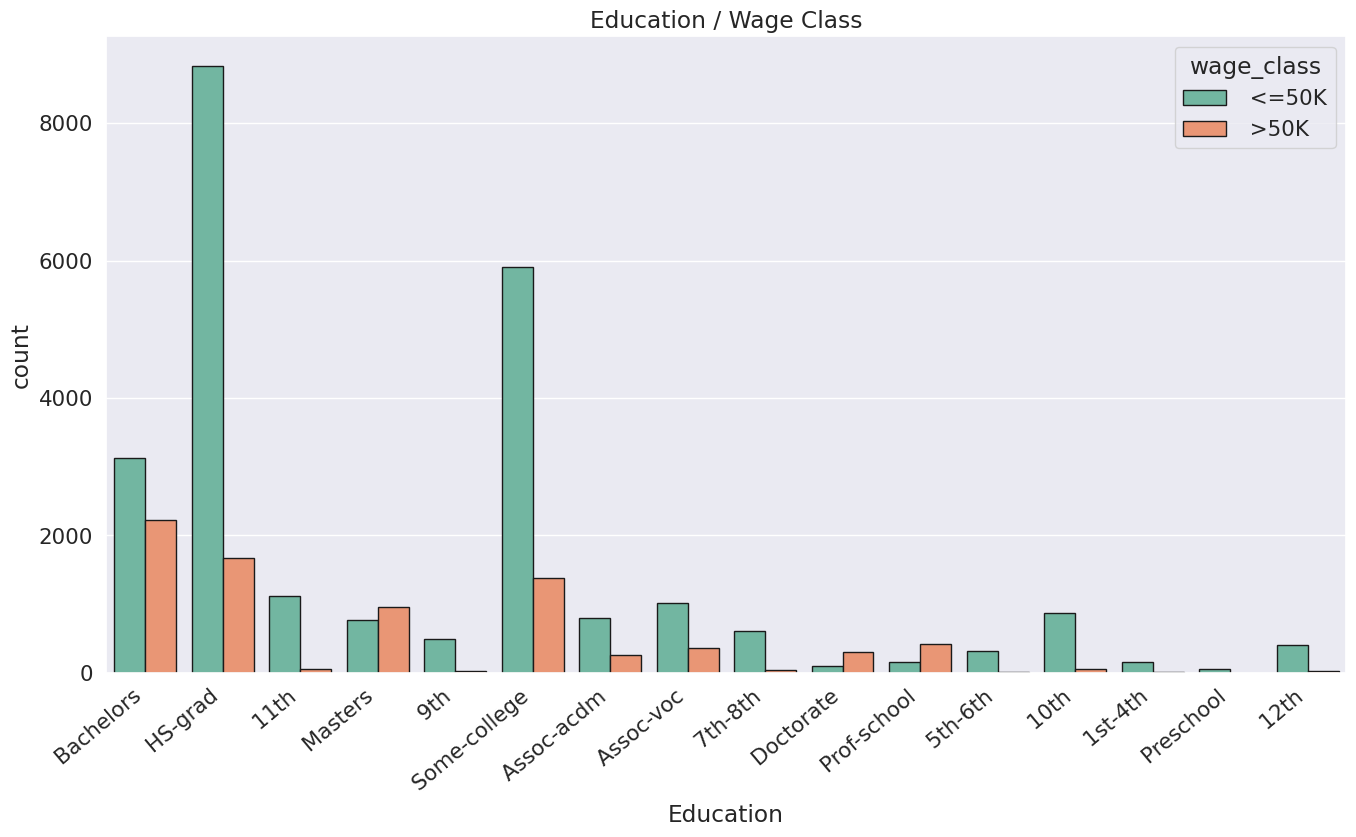

In [30]:
ax=sns.countplot(data=train,
    x='education',
    hue='wage_class',
    edgecolor='k',
    palette='Set2')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Education / Wage Class')
ax.set_xlabel('Education')
plt.show()

/tmp/ipykernel_700/3305184454.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax=sns.distplot(train['age'],hist_kws=dict(edgecolor="k", linewidth=2),kde_kws={"color": "#ce0d55", "lw": 2})


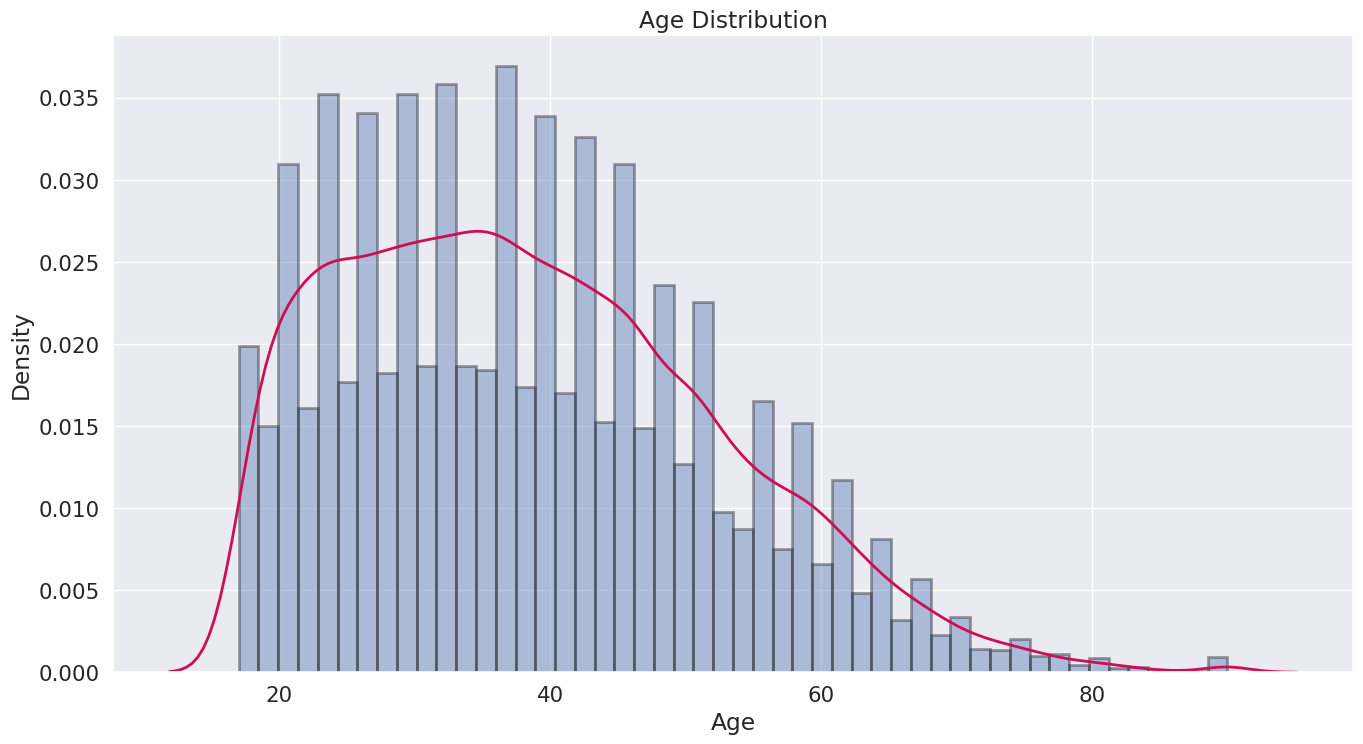

In [31]:
ax=sns.distplot(train['age'],hist_kws=dict(edgecolor="k", linewidth=2),kde_kws={"color": "#ce0d55", "lw": 2})
ax.set_title('Age Distribution')
ax.set_xlabel('Age')
plt.show()

/tmp/ipykernel_700/3765621809.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax=sns.distplot(train['hours_per_week'],hist_kws=dict(edgecolor="k", linewidth=2),kde_kws={"color": "#ce0d55", "lw": 2})


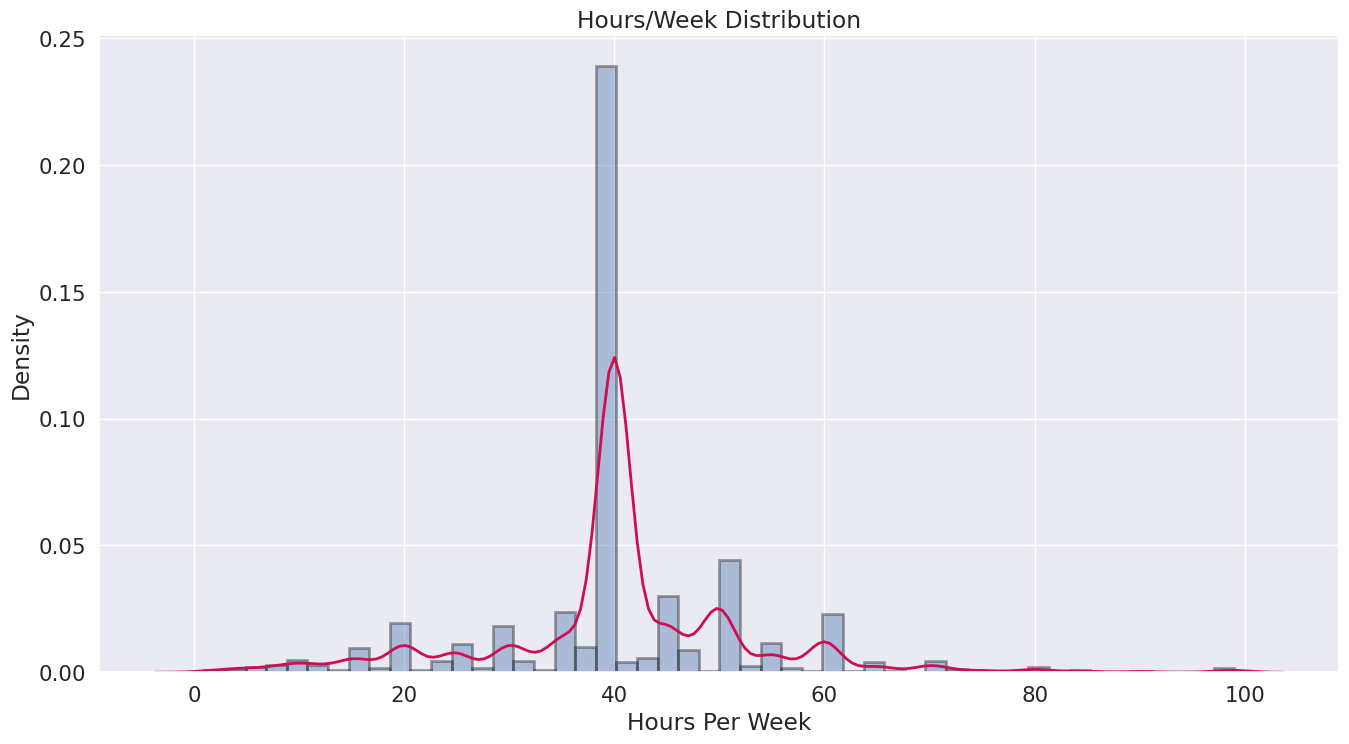

In [32]:
ax=sns.distplot(train['hours_per_week'],hist_kws=dict(edgecolor="k", linewidth=2),kde_kws={"color": "#ce0d55", "lw": 2})
ax.set_title('Hours/Week Distribution')
ax.set_xlabel('Hours Per Week')
plt.show()

/tmp/ipykernel_700/1789540408.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax=sns.distplot(train['capital_loss'],bins=10,kde=False,hist_kws=dict(edgecolor="k", linewidth=2))


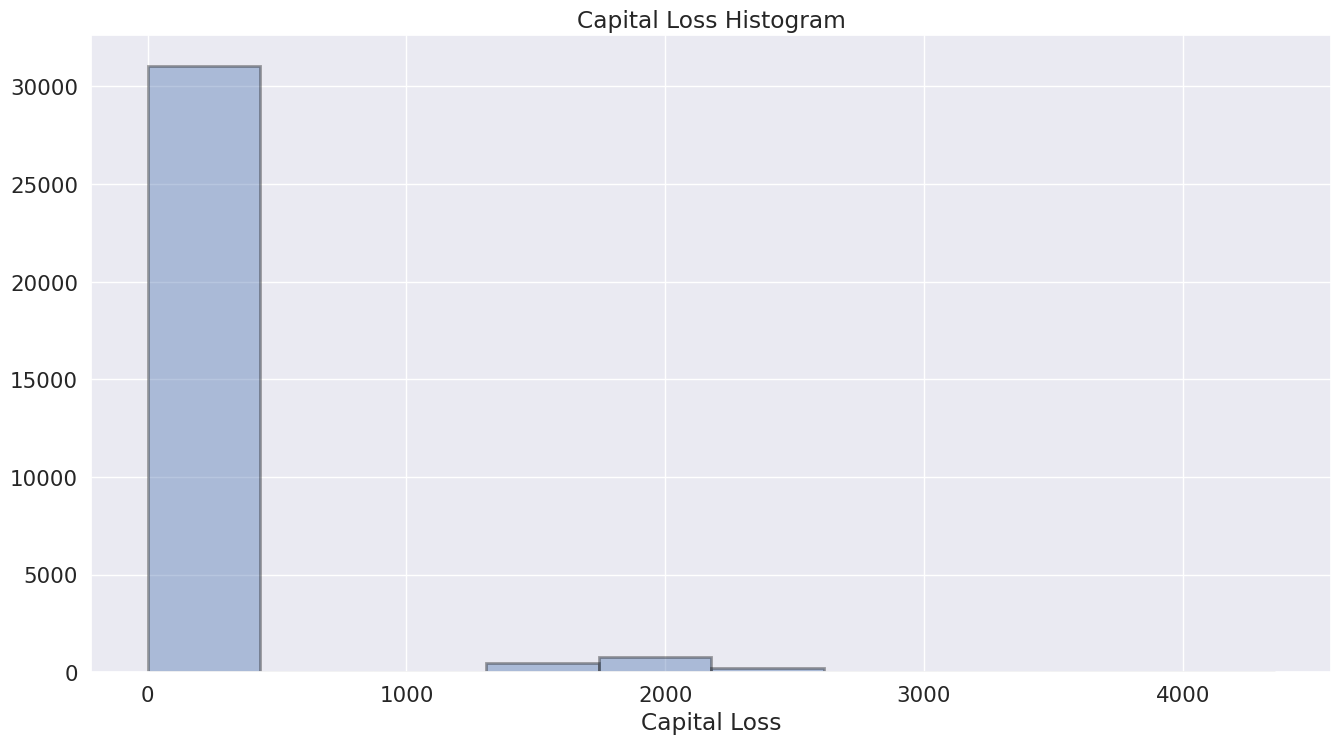

In [33]:
ax=sns.distplot(train['capital_loss'],bins=10,kde=False,hist_kws=dict(edgecolor="k", linewidth=2))
ax.set_title('Capital Loss Histogram')
ax.set_xlabel('Capital Loss')
plt.show()

/tmp/ipykernel_700/1069027400.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax=sns.distplot(train['capital_gain'],bins=10,kde=False,hist_kws=dict(edgecolor="k", linewidth=2))


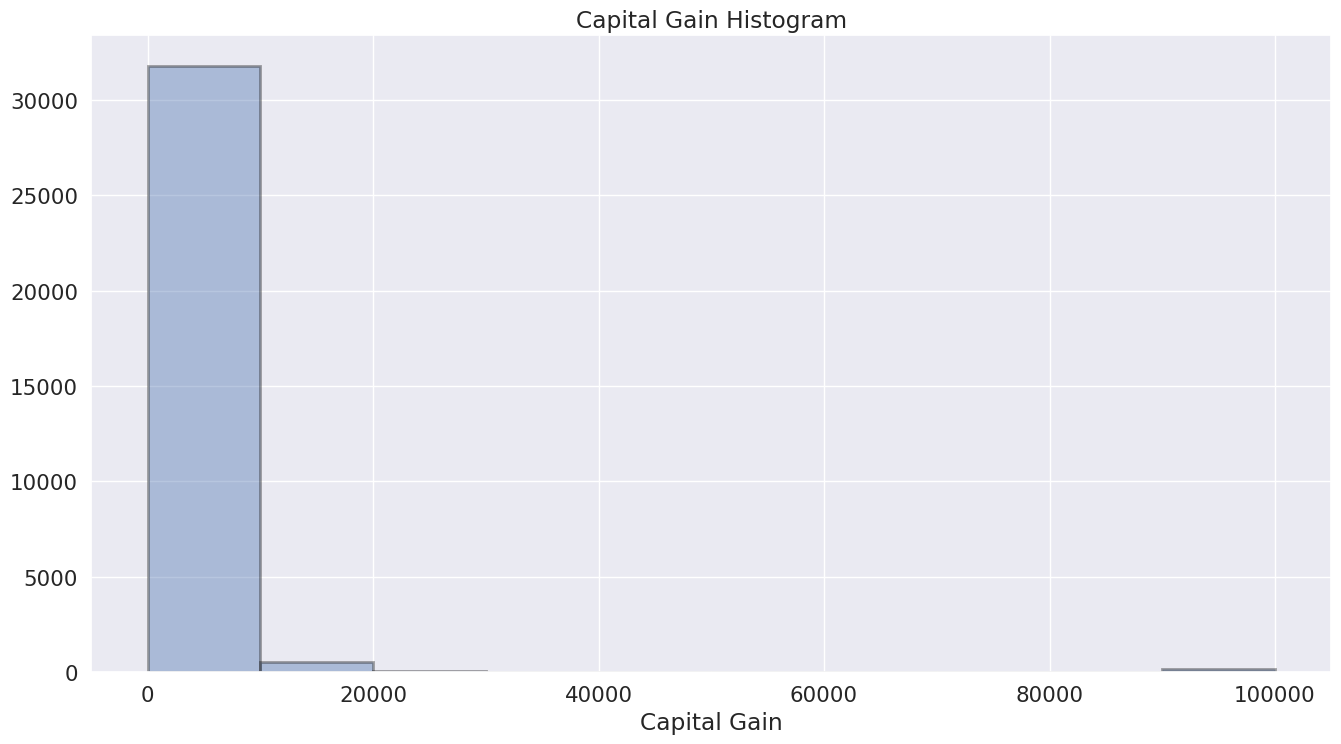

In [34]:
ax=sns.distplot(train['capital_gain'],bins=10,kde=False,hist_kws=dict(edgecolor="k", linewidth=2))
ax.set_title('Capital Gain Histogram')
ax.set_xlabel('Capital Gain')
plt.show()

/tmp/ipykernel_700/3520604294.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


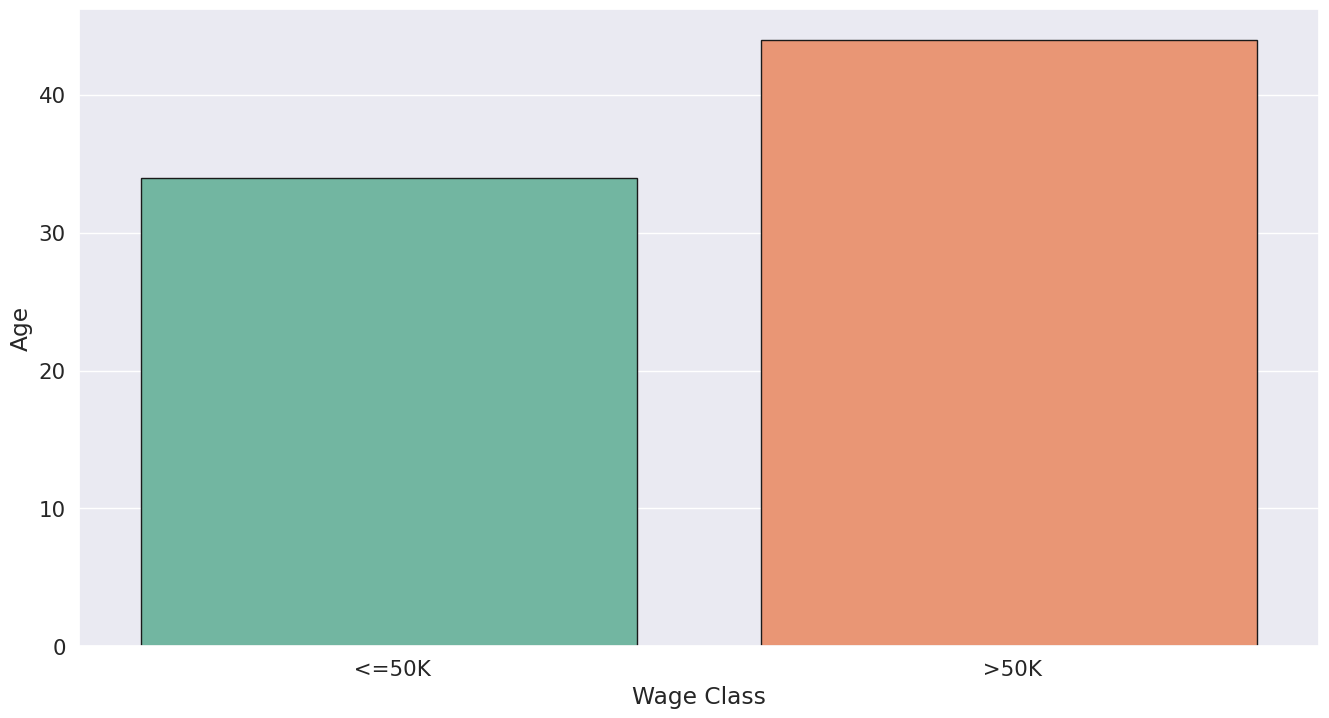

In [37]:
#median age for each wage_class
median_age = train.groupby('wage_class')['age'].median()

ax = sns.barplot(
    x=median_age.index,
    y=median_age.values,
    edgecolor='k',
    palette='Set2'
)

ax.set_ylabel('Age')
ax.set_xlabel('Wage Class')
plt.show()

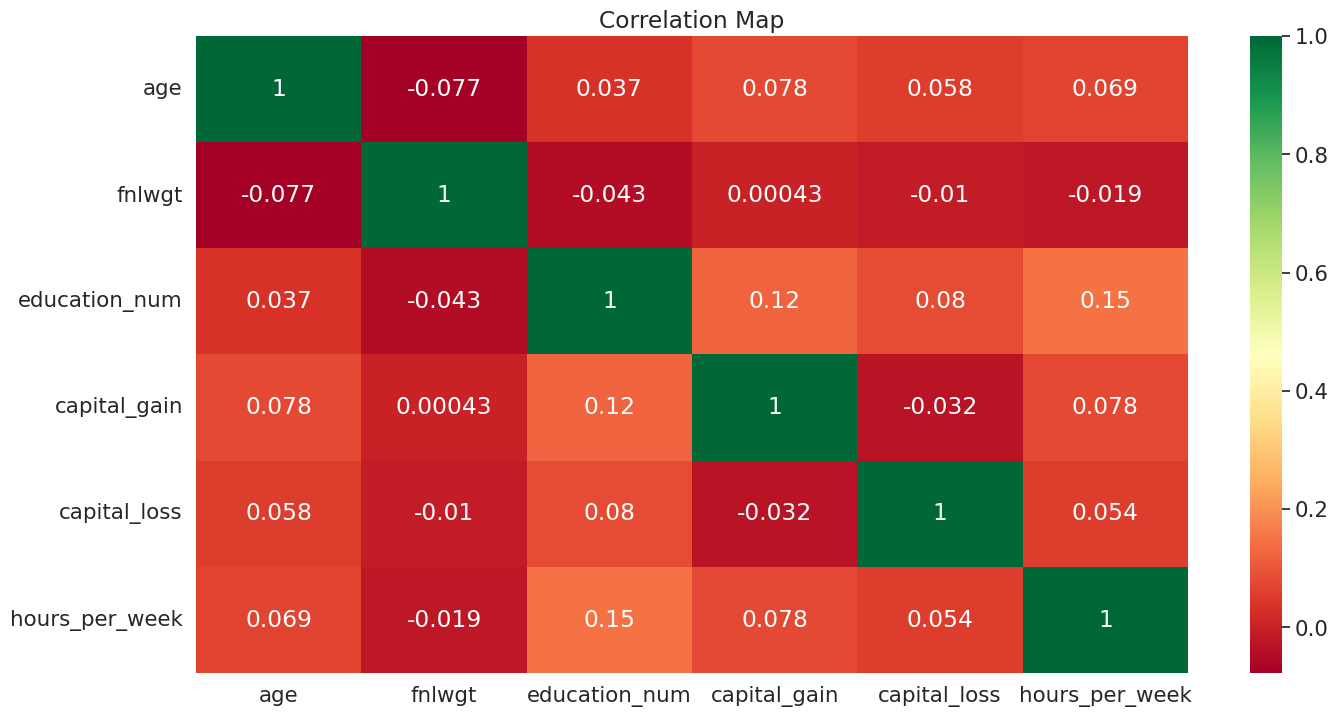

In [39]:
numeric_corr = corr_train.select_dtypes(include='number')

ax = sns.heatmap(
    numeric_corr.corr(),
    cmap='RdYlGn',
    annot=True
)

ax.set_title('Correlation Map')
plt.show()

---

### Test Set

In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workclass       16281 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education_num   16281 non-null  int64 
 5   marital_status  16281 non-null  object
 6   occupation      16281 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital_gain    16281 non-null  int64 
 11  capital_loss    16281 non-null  int64 
 12  hours_per_week  16281 non-null  int64 
 13  native_country  16281 non-null  object
 14  wage_class      16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [41]:
test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [42]:
train.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [43]:
#find out numerical and categorical features for test set

numerical_features_test=[feature for feature in test.columns if test[feature].dtype!='O']
categorical_features_test=[feature for feature in  test.columns if  test[feature].dtype=='O' and feature!='wage_class']

print('categorical features: ''\n',categorical_features_test)
print('\n')
print('numerical features: ''\n',numerical_features_test)

categorical features: 
 ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


numerical features: 
 ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


In [44]:
#Check for missing values
for feature in test.columns:
    print(feature,':', test[feature].isnull().sum())

age : 0
workclass : 0
fnlwgt : 0
education : 0
education_num : 0
marital_status : 0
occupation : 0
relationship : 0
race : 0
sex : 0
capital_gain : 0
capital_loss : 0
hours_per_week : 0
native_country : 0
wage_class : 0


In [45]:
#Find out distinct values for each numerical feature
for feature in numerical_features_test:
    print(feature,':', test[feature].nunique())

age : 73
fnlwgt : 12787
education_num : 16
capital_gain : 113
capital_loss : 82
hours_per_week : 89


In [46]:
#Find out distinct values for each categorical feature
for feature in categorical_features_test:
    print(feature,':', test[feature].nunique())

workclass : 9
education : 16
marital_status : 7
occupation : 15
relationship : 6
race : 5
sex : 2
native_country : 41


In [47]:
#for each categorical value we calculate relative frequency of unique classes.
for feature in categorical_features_test:
    freq_test=test[feature].value_counts('f').rename_axis(feature).reset_index(name='relative frequency')
    print('\n')
    print(freq_test)



           workclass  relative frequency
0            Private            0.688533
1   Self-emp-not-inc            0.081138
2          Local-gov            0.064062
3                  ?            0.059149
4          State-gov            0.041951
5       Self-emp-inc            0.035563
6        Federal-gov            0.028991
7        Without-pay            0.000430
8       Never-worked            0.000184


        education  relative frequency
0         HS-grad            0.324489
1    Some-college            0.220318
2       Bachelors            0.163995
3         Masters            0.057367
4       Assoc-voc            0.041705
5            11th            0.039125
6      Assoc-acdm            0.032799
7            10th            0.028008
8         7th-8th            0.018979
9     Prof-school            0.015847
10            9th            0.014864
11           12th            0.013758
12      Doctorate            0.011117
13        5th-6th            0.010810
14        1st-4t

---

### Feature Engineering

In [48]:
#convert <=50K and >50K to 0, 1 respectively
encoder=LabelEncoder()
train['wage_class']=encoder.fit_transform(train['wage_class'])

In [49]:
categorical_features=[feature for feature in  train.columns if  train[feature].dtype=='O' and feature!='wage_class']
for feature in categorical_features:
    freq=train[feature].value_counts().rename_axis(feature).reset_index(name='frequency')
    print('\n')
    print(freq)




           workclass  frequency
0            Private      22696
1   Self-emp-not-inc       2541
2          Local-gov       2093
3                  ?       1836
4          State-gov       1298
5       Self-emp-inc       1116
6        Federal-gov        960
7        Without-pay         14
8       Never-worked          7


        education  frequency
0         HS-grad      10501
1    Some-college       7291
2       Bachelors       5355
3         Masters       1723
4       Assoc-voc       1382
5            11th       1175
6      Assoc-acdm       1067
7            10th        933
8         7th-8th        646
9     Prof-school        576
10            9th        514
11           12th        433
12      Doctorate        413
13        5th-6th        333
14        1st-4th        168
15      Preschool         51


           marital_status  frequency
0      Married-civ-spouse      14976
1           Never-married      10683
2                Divorced       4443
3               Separated       1

In [50]:
#transform country feature to be 1 if country is the United States. Otherwise is equal to 0
train['native_country']=np.where(train['native_country']==' United-States',1,0)

In [51]:
#transform marital status and concatenate some classes to reduce distinct classes
train['marital_status']=train['marital_status'].replace({' Married-civ-spouse': 'Married', ' Never-married': 'Single',  
                                                        ' Separated':'Divorced', ' Married-spouse-absent' : 'Divorced', 
                                                         ' Divorced':'Divorced', 
                                                         ' Married-AF-spouse' :'Divorced', ' Widowed':'Widowed' })

In [52]:
#transform workclass feature to be 1 if the workclass is Private and 0 if doesn't
train['workclass']=np.where(train['workclass']==' Private',1,0)

In [53]:
#transform workclass feature to be 1 if the Sex is Male and 0 if doesn't
train['sex']=np.where(train['sex']==' Male',1,0)

In [54]:
#transform workclass feature to be 1 if the Race is White and 0 if doesn't
train['race']=np.where(train['race']==' White',1,0)

In [55]:
#create ordered label for education 
education_mapping={' Preschool':0,' 1st-4th':1,' 5th-6th':2,' 7th-8th':3,' 9th':4,' 10th':5,
                   ' 11th':6,' 12th':7,' HS-grad':8,' Some-college':0,' Assoc-acdm':10,
                   ' Assoc-voc':11, ' Bachelors':12, ' Prof-school':13, ' Masters':14,' Doctorate':15
                   }
train['education']=train['education'].map(education_mapping)

In [56]:
relationship_ordered=train.groupby(['relationship'])['wage_class'].count().sort_values().index
relationship_ordered={k:i for i,k in enumerate(relationship_ordered,0)}
train['relationship']=train['relationship'].map(relationship_ordered) 

In [57]:
occupation_ordered=train.groupby(['occupation'])['wage_class'].count().sort_values().index
occupation_ordered={k:i for i,k in enumerate(occupation_ordered,0)}
train['occupation']=train['occupation'].map(occupation_ordered)

In [58]:
marital_ordered=train.groupby(['marital_status'])['wage_class'].count().sort_values().index
marital_ordered={k:i for i,k in enumerate(marital_ordered,0)}
train['marital_status']=train['marital_status'].map(marital_ordered)

In [59]:
train.head(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,0,77516,12,13,2,11,4,1,1,2174,0,40,1,0
1,50,0,83311,12,13,3,12,5,1,1,0,0,13,1,0
2,38,1,215646,8,9,1,5,4,1,1,0,0,40,1,0
3,53,1,234721,6,7,3,5,5,0,1,0,0,40,1,0
4,28,1,338409,12,13,3,14,1,0,0,0,0,40,0,0
5,37,1,284582,14,14,3,12,1,1,0,0,0,40,1,0
6,49,1,160187,4,5,1,9,4,0,0,0,0,16,0,0
7,52,0,209642,8,9,3,12,5,1,1,0,0,45,1,1
8,31,1,45781,14,14,2,14,4,1,0,14084,0,50,1,1
9,42,1,159449,12,13,3,12,5,1,1,5178,0,40,1,1


In [60]:
train.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

In [61]:
train.drop('fnlwgt',axis=1,inplace=True) # it is not a useful feature for predicting the wage class

In [62]:
#scaling the train set with StandardScaler
scaler=StandardScaler()
scaled_features_train=scaler.fit_transform(train.drop('wage_class',axis=1))
scaled_features_train=pd.DataFrame(scaled_features_train, columns=train.drop('wage_class',axis=1).columns)

In [63]:
#undersampling the train set
under=OneSidedSelection()
X_train_res, y_train_res=under.fit_resample(scaled_features_train, train['wage_class'])


#oversampling the train set
sm=SMOTE()
X_train_res, y_train_res= sm.fit_resample(X_train_res, y_train_res)

X_train_res=pd.DataFrame(X_train_res, columns=train.drop('wage_class',axis=1).columns)



#creating the final train 
final_train=pd.concat([X_train_res, y_train_res],axis=1)

In [64]:
final_train.head(10)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,-0.042642,-1.516792,-1.532107,-0.031360,-0.256985,-0.265399,0.167065,0.413020,-1.422331,-0.145920,-0.21666,-1.655225,0.340954,0
1,0.030671,-1.516792,1.053613,1.134739,-0.256985,0.348115,0.167065,0.413020,0.703071,0.148453,-0.21666,-0.035429,0.340954,0
2,0.837109,-1.516792,1.053613,1.134739,0.924726,0.654872,0.902673,0.413020,0.703071,-0.145920,-0.21666,-2.222153,0.340954,0
3,-0.042642,0.659286,0.191706,-0.420060,-1.438697,-1.492427,0.167065,0.413020,0.703071,-0.145920,-0.21666,-0.035429,0.340954,0
4,1.057047,0.659286,-0.239247,-1.197459,0.924726,-1.492427,0.902673,-2.421192,0.703071,-0.145920,-0.21666,-0.035429,0.340954,0
5,-0.775768,0.659286,1.053613,1.134739,0.924726,1.268386,-2.039757,-2.421192,-1.422331,-0.145920,-0.21666,-0.035429,-2.932948,0
6,0.763796,0.659286,-0.670200,-1.974858,-1.438697,-0.265399,0.167065,-2.421192,-1.422331,-0.145920,-0.21666,-1.979184,-2.932948,0
7,-1.142331,0.659286,1.053613,1.134739,-0.256985,0.348115,-0.568542,0.413020,-1.422331,-0.145920,-0.21666,-0.845327,0.340954,0
8,-0.482518,0.659286,0.622659,0.746039,-0.256985,0.041358,0.167065,-2.421192,0.703071,-0.145920,-0.21666,0.774468,0.340954,0
9,-0.335892,0.659286,-0.885677,-2.363558,0.924726,-1.185670,0.902673,-2.421192,0.703071,-0.145920,-0.21666,0.369519,-2.932948,0


In [65]:
final_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47008 entries, 0 to 47007
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             47008 non-null  float64
 1   workclass       47008 non-null  float64
 2   education       47008 non-null  float64
 3   education_num   47008 non-null  float64
 4   marital_status  47008 non-null  float64
 5   occupation      47008 non-null  float64
 6   relationship    47008 non-null  float64
 7   race            47008 non-null  float64
 8   sex             47008 non-null  float64
 9   capital_gain    47008 non-null  float64
 10  capital_loss    47008 non-null  float64
 11  hours_per_week  47008 non-null  float64
 12  native_country  47008 non-null  float64
 13  wage_class      47008 non-null  int64  
dtypes: float64(13), int64(1)
memory usage: 5.0 MB


In [66]:
final_train['wage_class'].value_counts() #now train set is balanced

wage_class
0    23504
1    23504
Name: count, dtype: int64

### Test Set

In [67]:
test['wage_class']=np.where(test['wage_class']== ' >50K.',1,0)

In [68]:
test['wage_class'].value_counts()

wage_class
0    12435
1     3846
Name: count, dtype: int64

In [69]:
#transform country feature to be 1 if country is the United States. Otherwise is equal to 0
test['native_country']=np.where(test['native_country']==' United-States',1,0)

In [70]:
#transform workclass feature to be 1 if the workclass is Private and 0 if doesn't
test['workclass']=np.where(test['workclass']==' Private',1,0)

In [71]:
#transform workclass feature to be 1 if the Sex is Male and 0 if doesn't
test['sex']=np.where(test['sex']==' Male',1,0)

In [72]:
test['race']=np.where(test['race']==' White',1,0)

In [73]:
test['education']=test['education'].map(education_mapping)

In [74]:
test['relationship']=test['relationship'].map(relationship_ordered) 

In [75]:
test['occupation']=test['occupation'].map(occupation_ordered)

In [76]:
#transform marital status and concatenate some classes to reduce distinct classes
test['marital_status']=test['marital_status'].replace({' Married-civ-spouse': 'Married', ' Never-married': 'Single',  
                                                        ' Separated':'Divorced', ' Married-spouse-absent' : 'Divorced', 
                                                         ' Divorced':'Divorced', 
                                                         ' Married-AF-spouse' :'Divorced', ' Widowed':'Widowed' })

In [77]:
test['marital_status']=test['marital_status'].map(marital_ordered)

In [78]:
test.head(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,1,226802,6,7,2,8,3,0,1,0,0,40,1,0
1,38,1,89814,8,9,3,4,5,1,1,0,0,50,1,0
2,28,0,336951,10,12,3,2,5,1,1,0,0,40,1,1
3,44,1,160323,0,10,3,8,5,0,1,7688,0,40,1,1
4,18,0,103497,0,10,2,7,3,1,0,0,0,30,1,0
5,34,1,198693,5,6,2,9,4,1,1,0,0,30,1,0
6,29,0,227026,8,9,2,7,2,0,1,0,0,40,1,0
7,63,0,104626,13,15,3,14,5,1,1,3103,0,32,1,1
8,24,1,369667,0,10,2,9,2,1,0,0,0,40,1,0
9,55,1,104996,3,4,3,13,5,1,1,0,0,10,1,0


In [79]:
test.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

In [80]:
test.drop('fnlwgt',axis=1,inplace=True)

In [81]:
scaled_features_test=scaler.transform(test.drop('wage_class',axis=1))
scaled_features_test=pd.DataFrame(scaled_features_test, columns=test.drop('wage_class',axis=1).columns)

final_test=pd.concat([scaled_features_test,test['wage_class']],axis=1)

In [82]:
final_test.head(10)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,-0.995706,0.659286,-0.239247,-1.197459,-0.256985,-0.572156,-0.568542,-2.421192,0.703071,-0.145920,-0.21666,-0.035429,0.340954,0
1,-0.042642,0.659286,0.191706,-0.420060,0.924726,-1.799184,0.902673,0.413020,0.703071,-0.145920,-0.21666,0.774468,0.340954,0
2,-0.775768,-1.516792,0.622659,0.746039,0.924726,-2.412698,0.902673,0.413020,0.703071,-0.145920,-0.21666,-0.035429,0.340954,1
3,0.397233,0.659286,-1.532107,-0.031360,0.924726,-0.572156,0.902673,-2.421192,0.703071,0.895083,-0.21666,-0.035429,0.340954,1
4,-1.508894,-1.516792,-1.532107,-0.031360,-0.256985,-0.878913,-0.568542,0.413020,-1.422331,-0.145920,-0.21666,-0.845327,0.340954,0
5,-0.335892,0.659286,-0.454724,-1.586158,-0.256985,-0.265399,0.167065,0.413020,0.703071,-0.145920,-0.21666,-0.845327,0.340954,0
6,-0.702455,-1.516792,0.191706,-0.420060,-0.256985,-0.878913,-1.304150,-2.421192,0.703071,-0.145920,-0.21666,-0.035429,0.340954,0
7,1.790173,-1.516792,1.269089,1.912138,0.924726,1.268386,0.902673,0.413020,0.703071,0.274245,-0.21666,-0.683348,0.340954,1
8,-1.069018,0.659286,-1.532107,-0.031360,-0.256985,-0.265399,-1.304150,0.413020,-1.422331,-0.145920,-0.21666,-0.035429,0.340954,0
9,1.203672,0.659286,-0.885677,-2.363558,0.924726,0.961629,0.902673,0.413020,0.703071,-0.145920,-0.21666,-2.465122,0.340954,0


---

##### Feature Selection

In [83]:
X=final_train.drop('wage_class',axis=1)
y=final_train['wage_class']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [85]:
model=xgb.XGBClassifier()

In [86]:
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


/tmp/ipykernel_700/2857219146.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│    4 │   edgecolor='k',                                                                          │
│    5 │   palette='Set2'                                                                          │
│    6 )                                                                                           │
│ ❱  7 ax=sns.barplot(feat_importances.index, feat_importances.values ,edgecolor='k', palette='    │
│    8 ax.set_ylabel('Feature Importance')                                                         │
│    9 ax.set_xlabel('Features')                                                                   │
│   10 ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: barplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only 
argument) were given

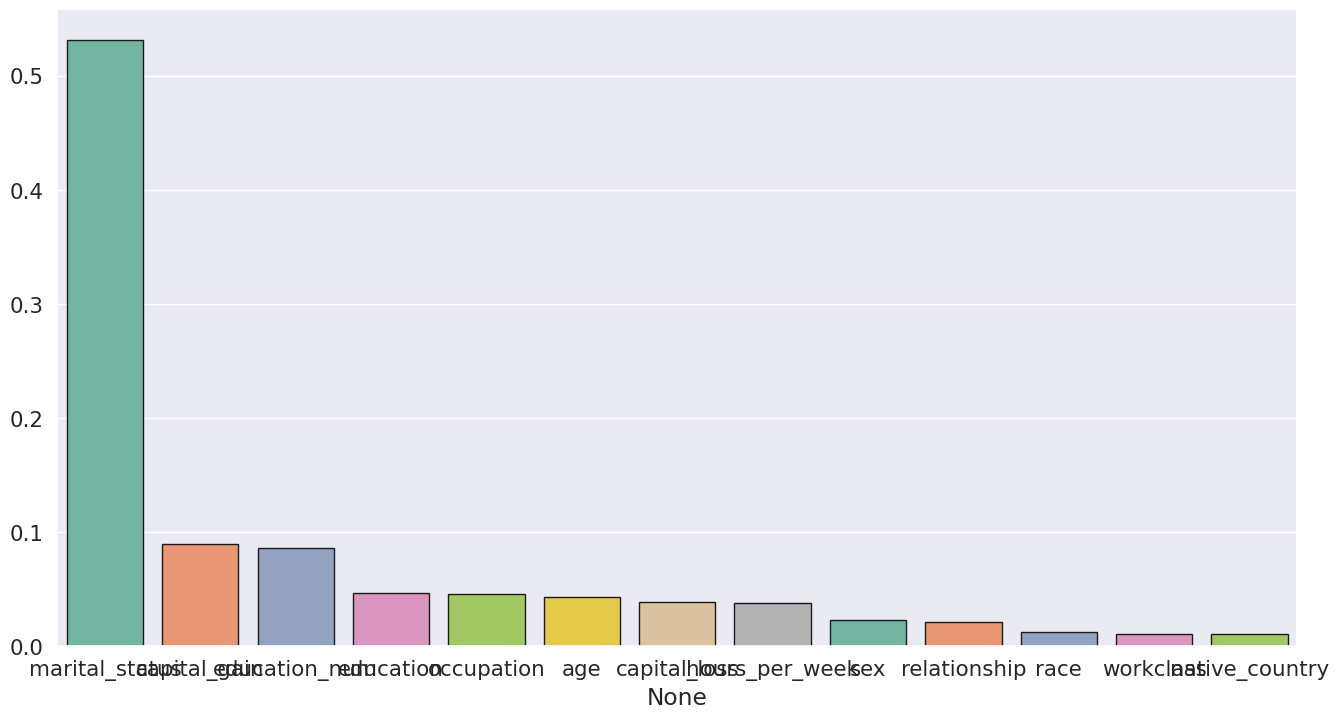

In [88]:
ax = sns.barplot(
    x=feat_importances.index,
    y=feat_importances.values,
    edgecolor='k',
    palette='Set2'
)
ax=sns.barplot(feat_importances.index, feat_importances.values ,edgecolor='k', palette='Set2')
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Features')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [89]:
final_train.drop(['native_country','race','workclass'],axis=1,inplace=True)
final_test.drop(['native_country','race','workclass'],axis=1,inplace=True)

# Model Selection

In [90]:
# XGBoost
xgb_classifier=xgb.XGBClassifier()
score_xgb=cross_val_score(xgb_classifier, X, y, cv=5, n_jobs=-1)

In [93]:
# Random Forest
rf=RandomForestClassifier()
score_rf=cross_val_score(rf, X, y, cv=5, n_jobs=-1)

In [97]:
# SVC
svc=SVC()
score_svc=cross_val_score(svc, X, y, cv=5, n_jobs=-1)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 # SVC                                                                                        │
│   2 svc=SVC()                                                                                    │
│ ❱ 3 score_svc=cross_val_score(svc, X, y, cv=5, n_jobs=-1)                                        │
│   4                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:218 in wrapper        │
│                                                                                                  │
│   215 │   │   │   │   │   │   prefer_skip_nested_validation or global_skip_validation            │
│   216 │   │   │   │   │   )                                                                      │
│   217 │   │   │   │   ):                                                                         │
│ ❱ 218 │   │   │   │   │   return func(*args, **kwargs)                                           │
│   219 │   │   │   except InvalidParameterError as e:                                             │
│   220 │   │   │   │   # When the function is just a wrapper around an estimator, we allow        │
│   221 │   │   │   │   # the function to delegate validation to the estimator, but we replace     │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:677 in            │
│ cross_val_score                                                                                  │
│                                                                                                  │
│    674 │   # To ensure multimetric format is not supported                                       │
│    675 │   scorer = check_scoring(estimator, scoring=scoring)                                    │
│    676 │                                                                                         │
│ ❱  677 │   cv_results = cross_validate(                                                          │
│    678 │   │   estimator=estimator,                                                              │
│    679 │   │   X=X,                                                                              │
│    680 │   │   y=y,                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:218 in wrapper        │
│                                                                                                  │
│   215 │   │   │   │   │   │   prefer_skip_nested_validation or global_skip_validation            │
│   216 │   │   │   │   │   )                                                                      │
│   217 │   │   │   │   ):                                                                         │
│ ❱ 218 │   │   │   │   │   return func(*args, **kwargs)                                           │
│   219 │   │   │   except InvalidParameterError as e:                                             │
│   220 │   │   │   │   # When the function is just a wrapper around an estimator, we allow        │
│   221 │   │   │   │   # the function to delegate validation to the estimator, but we replace     │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sklearn/model_selec

In [95]:
# Logistic Regression
logReg=LogisticRegression()
score_logReg=cross_val_score(logReg, X, y, cv=5, n_jobs=-1)

In [96]:
# KNN
knn=KNeighborsClassifier()
score_knn=cross_val_score(knn, X, y, cv=5, n_jobs=-1)

In [98]:
# AdaBoost
adaboost=AdaBoostClassifier()
score_adaboost=cross_val_score(adaboost, X, y, cv=5, n_jobs=-1)

In [99]:
#scores=pd.DataFrame({'Model':['XGBoost','Random Forest','SVC','Logistic Regression','KNN','Adaboost'],
#                    'Accuracy':[score_xgb.mean(),score_rf.mean(),score_svc.mean(),score_logReg.mean(),score_knn.mean(),
#                             score_adaboost.mean()]})

scores=pd.DataFrame({'Model':['XGBoost','Random Forest','Logistic Regression','KNN','Adaboost'],
                    'Accuracy':[score_xgb.mean(),score_rf.mean(),score_logReg.mean(),score_knn.mean(),
                             score_adaboost.mean()]})

In [100]:
print(scores)

                 Model  Accuracy
0              XGBoost  0.889573
1        Random Forest  0.897189
2  Logistic Regression  0.818818
3                  KNN  0.864619
4             Adaboost  0.840878


## Final Model Evaluation

In [101]:
X_train=final_train.drop('wage_class',axis=1)
y_train=final_train['wage_class']

X_test=final_test.drop('wage_class',axis=1)
y_test=final_test['wage_class']

In [102]:
xgb_classifier.fit(X_train,y_train)
y_pred=xgb_classifier.predict(X_test)

In [103]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90     12435
           1       0.66      0.78      0.72      3846

    accuracy                           0.85     16281
   macro avg       0.79      0.83      0.81     16281
weighted avg       0.87      0.85      0.86     16281



In [104]:
xgboost_auc=roc_auc_score(y_test,y_pred)
r_probs = [0 for _ in range(len(y_test))]
random_auc = roc_auc_score(y_test, r_probs)
print(xgboost_auc)

0.8286323829310228


In [105]:
probs=xgb_classifier.predict_proba(X_test)

In [106]:
probs=probs[:,1] #keep probabilities for one class

In [107]:
r_fpr, r_tpr, _=roc_curve(y_test,probs)
x=np.arange(0,1.01,0.01)

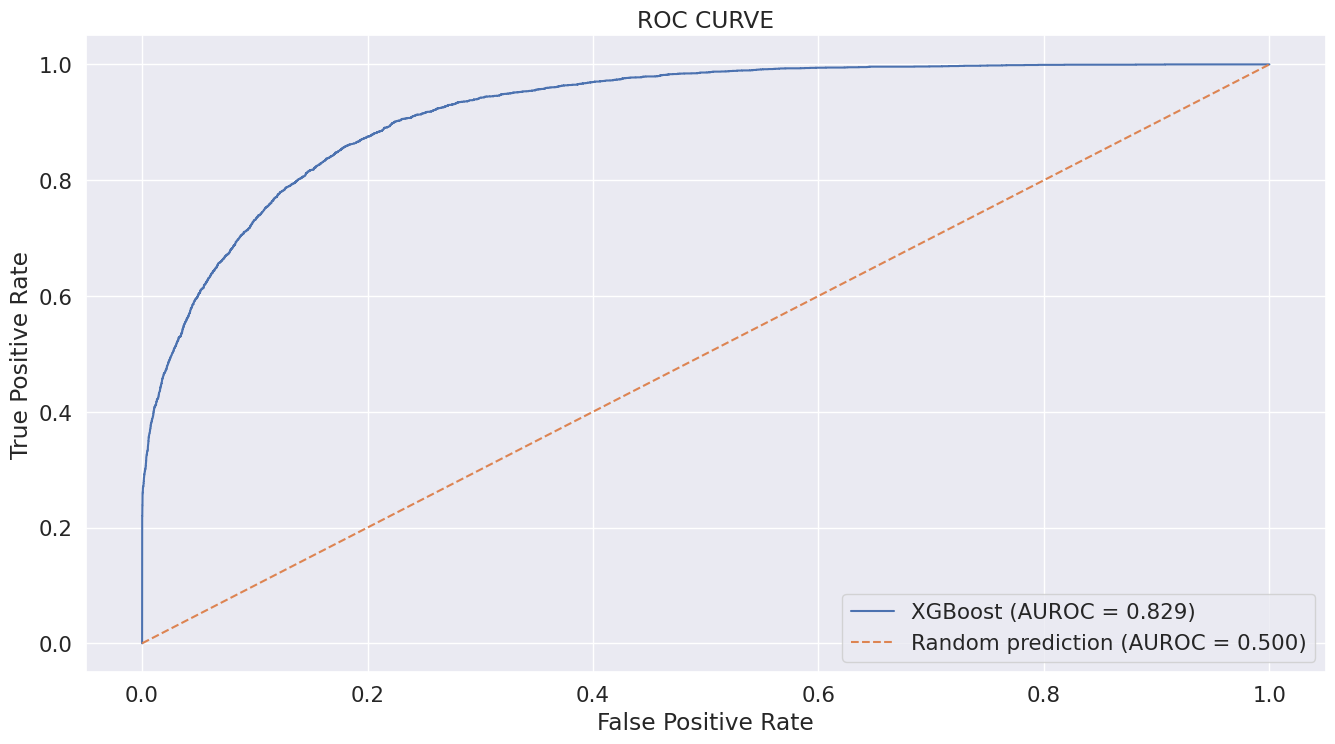

In [108]:
plt.plot(r_fpr, r_tpr, label='XGBoost (AUROC = %0.3f)' % xgboost_auc)
plt.plot(x,x, linestyle='--', label='Random prediction (AUROC = %0.3f)' % random_auc)
plt.legend()
plt.title('ROC CURVE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()